In [1]:
# Importaciones
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Configuración
pd.set_option('display.max_columns', None)
%matplotlib inline

In [4]:
# Cargar datos
viajes = pd.read_csv('Data.csv')
estaciones = pd.read_csv('stations.csv')

C:\Users\danyl\AppData\Local\Temp\ipykernel_31672\501646170.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  viajes = pd.read_csv('Data.csv')


In [5]:
# Mostrar estructura
print("Datos de viajes:")
print(viajes.head())
print("\nDatos de estaciones:")
print(estaciones.head())

Datos de viajes:
  Genero_Usuario  Edad_Usuario   Bici  Ciclo_Estacion_Retiro Fecha_Retiro  \
0              M            23  11925                    279   2019-01-06   
1              M            37     98                    103   2019-01-11   
2              M            26  10441                    174   2019-01-03   
3              M            32   9082                    176   2019-01-09   
4              M            55  10453                     45   2019-01-27   

  Hora_Retiro  Ciclo_Estacion_Arribo Fecha_Arribo Hora_Arribo  
0    06:52:49                    294   2019-01-06    06:58:59  
1    14:07:24                    254   2019-01-11    14:11:00  
2    10:18:32                     27   2019-01-03    10:26:10  
3    08:34:16                     19   2019-01-09    08:43:47  
4    08:10:21                    256   2019-01-27    08:28:22  

Datos de estaciones:
   id        lat        lon                           name
0   1  19.433571 -99.167809          1 RIO SENA-RIO BAL

In [6]:
# Convertir a datetime y extraer características temporales
viajes['Fecha_Retiro'] = pd.to_datetime(viajes['Fecha_Retiro'])
viajes['Hora_Retiro'] = pd.to_datetime(viajes['Hora_Retiro'], format='%H:%M:%S').dt.time
viajes['Fecha_Arribo'] = pd.to_datetime(viajes['Fecha_Arribo'])
viajes['Hora_Arribo'] = pd.to_datetime(viajes['Hora_Arribo'], format='%H:%M:%S').dt.time

In [7]:
# Crear variables de hora y día de la semana
viajes['Hora_Retiro_num'] = viajes['Hora_Retiro'].apply(lambda x: x.hour + x.minute/60)
viajes['Dia_Semana_Retiro'] = viajes['Fecha_Retiro'].dt.dayofweek

In [14]:
# Crear id usuario basado en edad genero y bici
viajes['Usuario_ID'] = (
    viajes['Genero_Usuario'].astype(str) + '_' +
    viajes['Edad_Usuario'].astype(str) + '_' +
    viajes['Bici'].astype(str)
)

In [12]:
# Construir matriz de preferencias
matriz_retiros = pd.crosstab(viajes['Usuario_ID'], viajes['Ciclo_Estacion_Retiro'])
matriz_arribos = pd.crosstab(viajes['Usuario_ID'], viajes['Ciclo_Estacion_Arribo'])

In [17]:
# Normalizar las matrices
scaler = StandardScaler()
matriz_retiros_norm = scaler.fit_transform(matriz_retiros)
matriz_arribos_norm = scaler.fit_transform(matriz_arribos)

In [18]:
# Configurar modelo NNMF
n_components = 10  # Numero de componentes latentes 
modelo_retiros = NMF(n_components=n_components, init='random', random_state=42)

In [20]:
# Aplicar NNMF
matriz_retiros_norm += np.abs(matriz_retiros_norm.min())  # Añadir el valor absoluto del mínimo
W_retiros = modelo_retiros.fit_transform(matriz_retiros_norm)
H_retiros = modelo_retiros.components_  

C:\Users\danyl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [22]:
# Descomposicion para arribos
matriz_arribos_norm += np.abs(matriz_arribos_norm.min())  # Añadir el valor absoluto del mínimo
modelo_arribos = NMF(n_components=n_components, init='random', random_state=42)
W_arribos = modelo_arribos.fit_transform(matriz_arribos_norm)
H_arribos = modelo_arribos.components_

C:\Users\danyl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\decomposition\_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


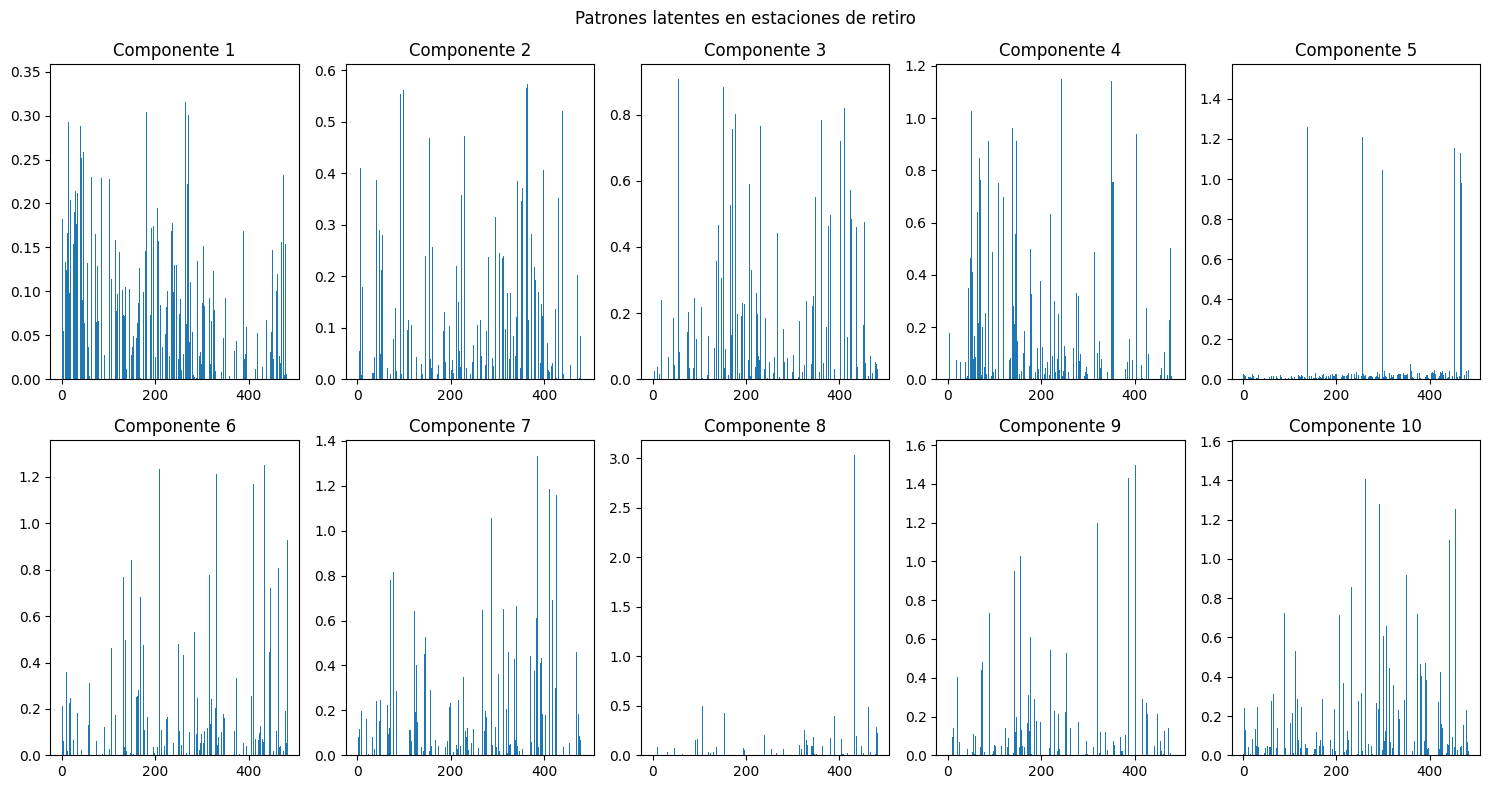

In [23]:
# Visualizar componentes latentes para retiros
plt.figure(figsize=(15, 8))
for i in range(n_components):
    plt.subplot(2, 5, i+1)
    plt.bar(range(len(H_retiros[i])), H_retiros[i])
    plt.title(f'Componente {i+1}')
plt.suptitle('Patrones latentes en estaciones de retiro')
plt.tight_layout()
plt.show()

In [24]:
def recomendar_estaciones(usuario_id, tipo='retiro', n_recomendaciones=5):
    if tipo == 'retiro':
        W = W_retiros
        H = H_retiros
        matriz = matriz_retiros
    else:
        W = W_arribos
        H = H_arribos
        matriz = matriz_arribos
    
    # Obtener índice del usuario
    try:
        usuario_idx = matriz.index.get_loc(usuario_id)
    except KeyError:
        print("Usuario no encontrado. Recomendando estaciones populares.")
        return matriz.sum().sort_values(ascending=False).head(n_recomendaciones).index.tolist()
    
    # Calcular predicción
    prediccion = np.dot(W[usuario_idx], H)
    
    # Obtener estaciones ya usadas
    estaciones_usadas = matriz.columns[matriz.loc[usuario_id] > 0]
    
    # Recomendar las mejores no usadas
    recomendaciones = []
    for estacion_idx in np.argsort(prediccion)[::-1]:
        estacion = matriz.columns[estacion_idx]
        if estacion not in estaciones_usadas:
            recomendaciones.append(estacion)
            if len(recomendaciones) >= n_recomendaciones:
                break
    
    return recomendaciones

In [25]:
# Seleccionar un usuario aleatorio para prueba
usuario_ejemplo = viajes['Usuario_ID'].sample(1).values[0]
print(f"Recomendaciones para usuario: {usuario_ejemplo}")

Recomendaciones para usuario: M_36_6795


In [26]:
# Recomendaciones de retiro
retiros_rec = recomendar_estaciones(usuario_ejemplo, tipo='retiro')
print("\nEstaciones recomendadas para retiro:")
print(estaciones[estaciones['id'].isin(retiros_rec)])



Estaciones recomendadas para retiro:
      id        lat        lon                                   name
99   100  19.428485 -99.133800            100 20 DE NOVIEMBRE-MESONES
201  202  19.436170 -99.198943    202 CALDERON DE LA BARCA-AV. HOMERO
363  364  19.383063 -99.185858        364 BOTICHELLI-CDA. DE GIORGONE
365  366  19.378345 -99.181973        366 PORFIRIO DÍAZ-AUGUSTO RODÍN
413  414  19.370187 -99.173712  414 PARROQUIA-JOSÉ IGNACIO BARTOLACHE


In [27]:
# Recomendaciones de arribo
arribos_rec = recomendar_estaciones(usuario_ejemplo, tipo='arribo')
print("\nEstaciones recomendadas para arribo:")
print(estaciones[estaciones['id'].isin(arribos_rec)])


Estaciones recomendadas para arribo:
      id        lat        lon  \
177  178  19.406833 -99.180457   
274  275  19.441062 -99.153164   
323  324  19.387247 -99.165655   
414  415  19.371498 -99.176020   
419  420  19.369723 -99.179640   

                                                 name  
177                  178 TAMAULIPAS-FRANCISCO MURGUÍA  
274  275 HÉROES FERROCARRILEROS-AV. INSURGENTES NORTE  
323                        324 AMORES-AVENIDA EUGENIA  
414                       415 SAN FRANCISCO-PARROQUÍA  
419                         420 MARÍA LUZ BRINGAS-OSO  


In [31]:
# Agrupamiento de estaciones por patrones horarios (K-means)
from sklearn.cluster import KMeans

# Preparar datos horarios
horario_estaciones = viajes.groupby(['Ciclo_Estacion_Retiro', 'Hora_Retiro_num']).size().unstack().fillna(0)

# Normalizar
horario_estaciones_norm = StandardScaler().fit_transform(horario_estaciones)

# Aplicar K-means
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(horario_estaciones_norm)

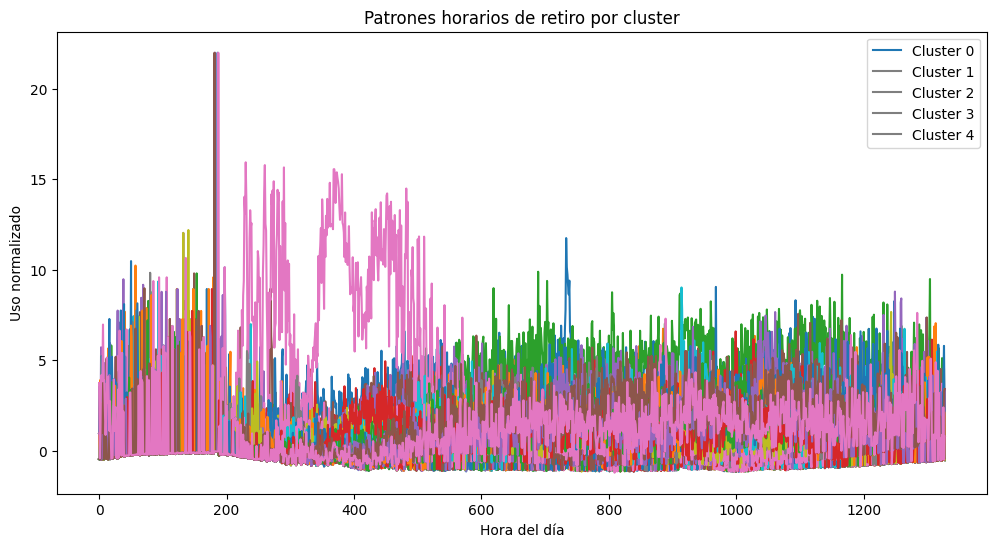

In [32]:
# Visualizar clusters
plt.figure(figsize=(12, 6))
for cluster in range(5):
    cluster_data = horario_estaciones_norm[clusters == cluster]
    for i in range(min(10, len(cluster_data))):  # Mostrar hasta 10 estaciones por cluster
        plt.plot(cluster_data[i], label=f'Cluster {cluster}' if i == 0 else "")
plt.title('Patrones horarios de retiro por cluster')
plt.xlabel('Hora del día')
plt.ylabel('Uso normalizado')
plt.legend()
plt.show()

In [34]:
# Recomendaciones basadas en hora del día
def recomendar_por_hora(usuario_id, hora, tipo='retiro', n_recomendaciones=5):
    # Primero obtener recomendaciones generales
    recomendaciones = recomendar_estaciones(usuario_id, tipo, n_recomendaciones*3)
    
    # Filtrar por estaciones populares en esa hora
    hora_approx = int(hora)
    estaciones_hora = viajes[viajes['Hora_Retiro_num'].between(hora_approx-1, hora_approx+1)]
    estaciones_hora = estaciones_hora['Ciclo_Estacion_Retiro'].value_counts().head(n_recomendaciones*2).index
    
    # Intersección de ambas listas
    recomendaciones_final = list(set(recomendaciones) & set(estaciones_hora))
    
    # Si no hay suficientes, completar con las generales
    if len(recomendaciones_final) < n_recomendaciones:
        recomendaciones_final.extend(recomendaciones[:n_recomendaciones-len(recomendaciones_final)])
    
    return recomendaciones_final[:n_recomendaciones]

In [35]:
# Ejemplo
hora_ejemplo = 17.5  # 5:30 PM
print(f"\nRecomendaciones para las {hora_ejemplo:.1f}:")
print(recomendar_por_hora(usuario_ejemplo, hora_ejemplo))


Recomendaciones para las 17.5:
[414, 366, 364, 202, 100]


In [36]:
# Evaluacion del modelo
from sklearn.model_selection import train_test_split

# Dividir datos
train, test = train_test_split(viajes, test_size=0.2, random_state=42)

In [38]:
# Función para evaluar precision
def evaluate_precision_at_k(model, test_data, k=5):
    hits = 0
    total = 0
    
    for usuario in test_data['Usuario_ID'].unique():
        viajes_usuario = test_data[test_data['Usuario_ID'] == usuario]
        estaciones_reales = viajes_usuario['Ciclo_Estacion_Retiro'].unique()
        
        if len(estaciones_reales) == 0:
            continue
            
        # Obtener recomendaciones
        recomendaciones = recomendar_estaciones(usuario, n_recomendaciones=k)
        
        # Verificar hits
        hits += len(set(recomendaciones) & set(estaciones_reales))
        total += k
    
    return hits / total

In [40]:
# Calcular metrica
precision_at_5 = evaluate_precision_at_k(modelo_retiros, test)
print(f"Precision: {precision_at_5:.3f}")

Precision: 0.000
